# Markovic


[TO DO]
- Create portfolios
  - equally weighted always
  - equally weighted start of the year
  - market portfolios
  - sectors
  - industries
- Create frontier
- Function to plot mean and variance of stocks
- Function to plot efficient frontier

### Variables

$$
\begin{equation}
C : \textrm{number of stocks}\\
T : \textrm{number of time observations} \\
\boldsymbol{\mu} : \textrm{mean stock return (C x 1)} \\
\boldsymbol{\Sigma} : \textrm{covariance matrix of returns (C x C)}
\end{equation}
$$

### Global Minimum Variance Portfolio

$$
\begin{equation}
\boldsymbol{w}_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota} \Sigma^{-1} \iota \\
\mu_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota}\mu' \Sigma^{-1} \iota \\
\sigma_{gmv}^2 = \frac{1}{\iota' \Sigma^{-1} \iota}
\end{equation}
$$

### Efficient Frontier

$$
\begin{equation}
\boldsymbol{w} = \lambda \boldsymbol{w}_{mu} + (1-\lambda) \boldsymbol{w}_{gmv}
\end{equation}
$$


In [1]:
from pathlib import Path
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def preprocess_column_name(column_name):
    column_name = column_name.title().replace(' ','').strip()
    return column_name


### Preprocess data (only do this once)



In [3]:
path_processed_ticker_data = Path('data') / 'tickers.csv'
path_returns = Path('data') / 'returns.csv'
raw_ticker_path = Path('data/nasdaq_screener_1614797288539.csv')
selected_columns = ['Symbol', 'Name', 'MarketCap', 'Country', 'Sector', 'Industry']

if not path_processed_ticker_data.exists():
    print('create processed ticker table')
    df_tickers = pd.read_csv(raw_ticker_path)
    df_tickers.columns = [preprocess_column_name(e) for e in df_tickers.columns]
    df_tickers = df_tickers[selected_columns]
    df_tickers.to_csv(path_processed_ticker_data, index=False)
else:
    df_tickers = pd.read_csv(path_processed_ticker_data)
    print('load ticker table')

if not path_returns.exists():
    print('get returns table')
    tickers = df_tickers['Symbol'].tolist()
    df_returns = yf.download( 
    tickers = ' '.join(df_tickers['Symbol'].tolist()[:250]),
    period = "1y",
    interval = "1d",
    group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
    )
    df_returns.to_csv(path_returns, index=False)
else:
    print('load returns table')
    df_returns = pd.read_csv(path_returns, header =[0,1])


load ticker table
load returns table


### Analysis

In [4]:
print(f"""
Number of unique Sectors : {df_tickers.Sector.unique().size}
Number of unique Industries : {df_tickers.Industry.unique().size}
""")


Number of unique Sectors : 13
Number of unique Industries : 134



In [5]:
data = df_returns
data.columns = data.columns.swaplevel()
data.sort_index(axis=1, level=0, inplace=True)
df = data['Close']
print(df.shape)
df.head(2)


(254, 250)


,A,AA,AAIC,AAIC^B,AAIC^C,AAN,AAP,AAT,AB,ABB,...,ATCO^D,ATCO^E,ATCO^G,ATCO^H,ATCO^I,ATEN,ATGE,ATH,AX,BANC^E
0,79.673676,12.94,6.00,NaN,NaN,NaN,129.333755,40.629932,28.571476,20.711140,...,NaN,NaN,NaN,NaN,NaN,6.51,29.870001,40.529999,23.590000,NaN
1,83.671242,12.88,6.04,NaN,NaN,NaN,131.884094,41.705006,29.603853,21.323954,...,NaN,NaN,NaN,NaN,NaN,6.60,31.320000,42.049999,23.959999,NaN


In [6]:
print(f"""
number of time steps: {df.shape[1]}
number of companies: {df.shape[0]}
number of companies with full history: {df.isnull().sum().eq(0).sum()}
number of companies with no history: {df.notnull().sum().eq(0).sum()}
""")

(df.notnull().mean()>0.9).mean()


number of time steps: 250
number of companies: 254
number of companies with full history: 163
number of companies with no history: 60



0.664

In [105]:
### Select non empty columns
df = df.T[df.isnull().sum().eq(0)].T
print(df.shape)
df.head(2)


(254, 163)


,A,AA,AAIC,AAP,AAT,AB,ABB,ABBV,ABC,ABEV,...,ASIX,ASPN,ASR,ASX,AT,ATCO,ATEN,ATGE,ATH,AX
0,79.673676,12.94,6.00,129.333755,40.629932,28.571476,20.711140,83.125305,84.387764,3.180123,...,14.63,8.50,164.250000,4.575711,2.20,9.669414,6.51,29.870001,40.529999,23.590000
1,83.671242,12.88,6.04,131.884094,41.705006,29.603853,21.323954,87.093140,88.819901,3.296469,...,14.66,8.54,168.160004,4.702004,2.28,9.575168,6.60,31.320000,42.049999,23.959999


### Get stock prices and Returns

In [12]:
p = df.to_numpy()
T, C = p.shape
r = np.divide((p[1:,:]-p[:-1,:]), p[:-1,:])
r_log = np.log(1+r)
u = r_log.mean(0)
Sigma = np.cov(r_log.T)
iota = np.ones((C,1))


### Realised returns

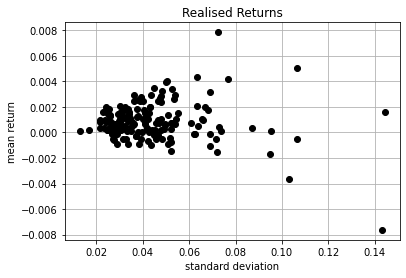

In [14]:
vol = np.sqrt(Sigma.diagonal())
x = vol
y = u

# plt.style.use('seaborn-whitegrid')
plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.title('Realised Returns')
plt.grid()
plt.show()


### Efficient Frontier

In [86]:
A = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), u)
B = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), iota)
C = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), iota)
D = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), u)

w_gmv = 1 / C * np.matmul(np.linalg.inv(Sigma), iota).reshape(-1,1)
u_gmv = B / C
std_gmv = np.sqrt(1 / C)

w_mu = 1 / D * np.matmul(np.linalg.inv(Sigma), u).reshape(-1,1)


In [87]:
print(f"""
Global Minimum Variance Portfolio
mean : {u_gmv[0][0]}
std : {std_gmv[0][0]}
""")


Global Minimum Variance Portfolio
mean : 4.501825401329196e-05
std : 0.0032848748243304595



In [102]:
c = 1.5
x = []
y = []
for u_targ in np.linspace(c*min(u), c*max(u), 200).tolist():
    _lambda = (B * C * u_targ - B * B) / (A * C - B * B)
    w = _lambda * w_mu + (1-_lambda) * w_gmv
    sigma = np.sqrt(np.matmul(np.matmul(w.T, Sigma), w))[0][0]
    x.append(sigma)
    y.append(u_targ)


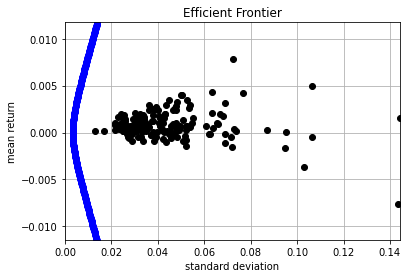

In [103]:
# plt.style.use('seaborn-whitegrid')    
vol = np.sqrt(Sigma.diagonal()).tolist()
min_sigma = min(x + vol)
max_sigma = max(x + vol)
min_return = min(y)
max_return = max(y)
plt.plot(x, y, 'o', color='blue')
x = vol
y = u
plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.xlim([0, max_sigma])
plt.ylim([min_return, max_return])
plt.title('Efficient Frontier')
plt.grid()
plt.show()


### PCA

In [123]:
import numpy as np
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=10)
pca.fit(r_log)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)


[0.41556516 0.06684347 0.06517647 0.03805881 0.03007245 0.0251107
 0.02419359 0.02251156 0.017542   0.01745416]
[6.35316547 2.54800399 2.51603112 1.92264114 1.70905085 1.56170849
 1.53292444 1.47867725 1.30529949 1.30202727]


In [141]:
w_pca = pca.components_[0]
w_pca *= 1/w_pca.sum()
u_pca = np.matmul(w_pca, u)
sigma_pca = np.sqrt(np.matmul(np.matmul(w_pca, Sigma), w_pca))
u_pca, sigma_pca

(0.0006406222874215396, 0.035427474459650644)

### Get industry prices and returns (equally weighted)

In [107]:
r_log

array([[ 0.04895609, -0.00464753,  0.00664454, ...,  0.0474022 ,
         0.03681696,  0.01556284],
       [-0.04721462, -0.07997799, -0.03710371, ..., -0.04773705,
        -0.04126801, -0.02536055],
       [-0.02389742, -0.07689377, -0.03496865, ...,  0.03326505,
        -0.07005556, -0.05409107],
       ...,
       [-0.00677098,  0.05647416,  0.00491401, ..., -0.01655076,
         0.00106916, -0.01008631],
       [-0.02871639,  0.11365329, -0.00738004, ...,  0.00753351,
         0.03949601,  0.03995151],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
industries equally weighted industry (I*C) * returns (C*T) = I*C*R
(C*R)


In [ ]:
G*C*T inner product G*C*T